In [1]:
#All Required Libraries
import os
import time
import math
import csv
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib.cm as cm
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint_adjoint as odeint #Otherwise only "odeint_adjoint"

In [2]:
#Configuration
method = 'rk4' #RK-45
data_size = 600 #300 every 10 seconds
batch_time = 30
batch_size = 20
niters = 5000
test_freq = 20
viz = True
gpu = 0
#device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [3]:
#Define Real ODE System
omega0 = torch.tensor(2*60*np.pi)
delta1star = -0.117919635325941
omega1star = 0
delta2star = 0.094729837775605
omega2star = 0
v1star = torch.tensor(2.04379374735951)
v2star = torch.tensor(1.98829642487374)
x0 = torch.tensor([[delta1star + np.pi/6], [omega1star], [delta2star], [omega2star]]).to(device)
t = torch.arange(0.,20., 1/30).to(device)

M1 = torch.tensor(100)
D1 = torch.tensor(10)
X1 = torch.tensor(0.963)
M2 = torch.tensor(12)
D2 = torch.tensor(10)
X2 = torch.tensor(0.667)
Bred = torch.tensor(-0.583070554936976)
Gred = torch.tensor(-0.003399828308670)
Pmech1star = torch.tensor(-0.513568531598284)
Pmech2star = torch.tensor(0.486559381709619)
#Pmech1star = torch.tensor(-v1star*v2star*Bred*np.sin(delta1star - delta2star) + v1star*v2star*Gred*np.cos(delta1star-delta2star))
#Pmech2star = torch.tensor(-v1star*v2star*Bred*np.sin(delta2star - delta1star) + v1star*v2star*Gred*np.cos(delta2star-delta1star))


class Real(nn.Module):
    def forward(self,t,x):
        dxdt = torch.zeros_like(x)
        dxdt[0] = x[1]
        dxdt[1] = (-D1*x[1]/omega0 + v1star*v2star*Bred*torch.sin(x[0]-x[2]) - v1star*v2star*Gred*torch.cos(x[0]-x[2]) + Pmech1star)*omega0/M1
        dxdt[2] = x[3]
        dxdt[3] = (-D2*x[3]/omega0 + v1star*v2star*Bred*torch.sin(x[2]-x[0]) - v1star*v2star*Gred*torch.cos(x[2]-x[0]) + Pmech2star)*omega0/M2
        self.dxdt = dxdt
        return dxdt

real_dynamics = Real()  
  
with torch.no_grad():
    true_x = odeint(real_dynamics, x0, t, method = method)

true_omega1 = true_x[:,1,0] / omega0
true_omega2 = true_x[:,3,0] / omega0

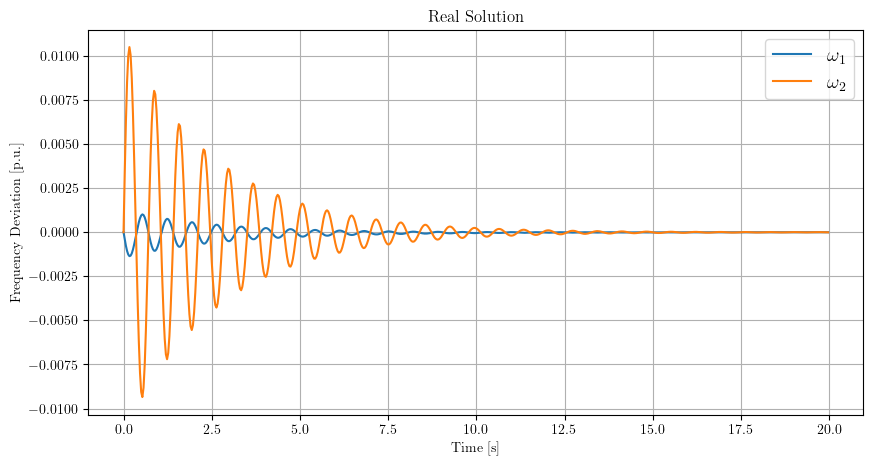

In [4]:
#Plot Correct Data
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(figsize=(10, 5))
plt.plot(t.cpu().numpy(), true_omega1.cpu().numpy(), label=r'$\omega_1$')
plt.plot(t.cpu().numpy(), true_omega2.cpu().numpy(), label=r'$\omega_2$')
plt.xlabel('Time [s]')
plt.ylabel('Frequency Deviation [p.u.]')
plt.title('Real Solution')
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

In [5]:
#Define Mini-Batches
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_x0 = true_x[s]
    batch_t = t[:batch_time]
    batch_x = torch.stack([true_x[s + i] for i in range(batch_time)], dim=0)
    return s.to(device), batch_x0.to(device), batch_t.to(device), batch_x.to(device)

In [6]:
#Visualization

def visualize(true_x, pred_x, t, omega0, viz, save_path):
    if viz:
        fig, axs = plt.subplots(2, 2, figsize=(12, 8))
        
        #Generator 1 - Rotor Angle and Frequency Deviation
        axs[0, 0].set_title('Generator 1 - Rotor Angle')
        axs[0, 0].set_xlabel('Time [s]')
        axs[0, 0].set_ylabel('Rotor Angle [p.u,]')
        axs[0, 0].plot(t.cpu().numpy(), true_x[:,0,0].cpu().numpy(), label=r'True $\delta_1$')
        axs[0, 0].plot(t.cpu().numpy(), pred_x[:,0,0].cpu().numpy(), '--', label=r'Predicted $\delta_1$')
        axs[0, 0].legend(fontsize=14)
        
        axs[0, 1].set_title('Generator 1 - Frequency Deviation')
        axs[0, 1].set_xlabel('Time [s]')
        axs[0, 1].set_ylabel('Frequency Deviation [p.u.]')
        axs[0, 1].plot(t.cpu().numpy(), true_x[:,1,0].cpu().numpy()/omega0, label=r'True $\omega_1$')
        axs[0, 1].plot(t.cpu().numpy(), pred_x[:,1,0].cpu().numpy()/omega0, '--', label=r'Predicted $\omega_1$')
        axs[0, 1].legend(fontsize=14)
        
        #Generator 2 - Rotor Angle and Frequency Deviation
        axs[1, 0].set_title('Generator 2 - Rotor Angle')
        axs[1, 0].set_xlabel('Time [s]')
        axs[1, 0].set_ylabel('Rotor Angle [p.u,]')
        axs[1, 0].plot(t.cpu().numpy(), true_x[:,2,0].cpu().numpy(), label=r'True $\delta_2$')
        axs[1, 0].plot(t.cpu().numpy(), pred_x[:,2,0].cpu().numpy(), '--', label=r'Predicted $\delta_2$')
        axs[1, 0].legend(fontsize=14)
        
        axs[1, 1].set_title('Generator 2 - Frequency Deviation')
        axs[1, 1].set_xlabel('Time [s]')
        axs[1, 1].set_ylabel('Frequency Deviation [p.u.]')
        axs[1, 1].plot(t.cpu().numpy(), true_x[:,3,0].cpu().numpy()/omega0, label=r'True $\omega_2$')
        axs[1, 1].plot(t.cpu().numpy(), pred_x[:,3,0].cpu().numpy()/omega0, '--', label=r'Predicted $\omega_2$')
        axs[1, 1].legend(fontsize=14)
        
        plt.tight_layout()
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
        plt.show()
        plt.close(fig)


In [7]:
#NN to learn the ODE

class NeuralODE(nn.Module):
    def __init__(self, M1, D1, M2, D2, V1, V2, B, G, Pmech1, Pmech2):
        super(NeuralODE, self).__init__()
        self.M1 = M1
        self.M2 = nn.Parameter(M2)
        self.D1 = D1
        self.D2 = nn.Parameter(D2)
        self.V1 = V1
        #self.V2 = V2
        self.V2 = nn.Parameter(V2)
        #self.B = B
        self.B = nn.Parameter(B)
        #self.G = G
        self.G = nn.Parameter(G)
        self.Pmech1 = Pmech1
        #self.Pmech2 = Pmech2
        self.Pmech2 = nn.Parameter(Pmech2)
        
    def forward(self, t, y):
        dydt = torch.zeros_like(y)
        dydt[0] = y[1]
        dydt[1] = (-self.D1*y[1]/omega0 + self.V1*self.V2*self.B*torch.sin(y[0]-y[2]) - self.V1*self.V2*self.G*torch.cos(y[0]-y[2]) + self.Pmech1)*omega0/self.M1
        dydt[2] = y[3]
        dydt[3] = (-self.D2*y[3]/omega0 + self.V1*self.V2*self.B*torch.sin(y[2]-y[0]) - self.V1*self.V2*self.G*torch.cos(y[2]-y[0]) + self.Pmech2)*omega0/self.M2
        self.dydt = dydt
        return dydt

In [8]:
#Check Learnable Parameters
Delta = 0.01 #Porcentual deviation from real value
#TargetPercent = 0.01
Treshold = 1e-11 #1e-7
M1_G = M1
D1_G = D1
M2_G = Delta*M2
D2_G = Delta*D2
V1_G = v1star
#V2_G = v2star
V2_G = Delta*v2star
#B_G = Bred
B_G = Delta*Bred
#G_G = Gred
G_G = Delta*Gred
Pmech1_G = Pmech1star
#Pmech2_G = Pmech2star
Pmech2_G = Delta*Pmech2star

func = NeuralODE(M1_G, D1_G, M2_G, D2_G, V1_G, V2_G, B_G, G_G, Pmech1_G, Pmech2_G).to(device)


for name, param in func.named_parameters():
    print(f"Name: {name}, Shape: {param.size()}, Requires Grad: {param.requires_grad}")


Name: M2, Shape: torch.Size([]), Requires Grad: True
Name: D2, Shape: torch.Size([]), Requires Grad: True
Name: V2, Shape: torch.Size([]), Requires Grad: True
Name: B, Shape: torch.Size([]), Requires Grad: True
Name: G, Shape: torch.Size([]), Requires Grad: True
Name: Pmech2, Shape: torch.Size([]), Requires Grad: True


M1: 100 M1_G: 100
D1: 10 D1_G: 10
M2: 12 M2_G: 11.399999618530273
D2: 10 D2_G: 9.5
V1: 2.0437936782836914 V1_G: 2.0437936782836914
V2: 1.988296389579773 V2_G: 1.8888815641403198
Bred: -0.5830705761909485 B_G: -0.5539170503616333
Gred: -0.003399828216060996 G_G: -0.0032298367004841566
Pmech1: -0.5135685205459595 Pmech1_G: -0.5135685205459595
Pmech2: 0.4865593910217285 Pmech2_G: 0.46223142743110657
Initial Parameters:
M2: 11.399999618530273
D2: 9.5
V2: 1.8888815641403198
B: -0.5539170503616333
G: -0.0032298367004841566
Pmech2: 0.46223142743110657


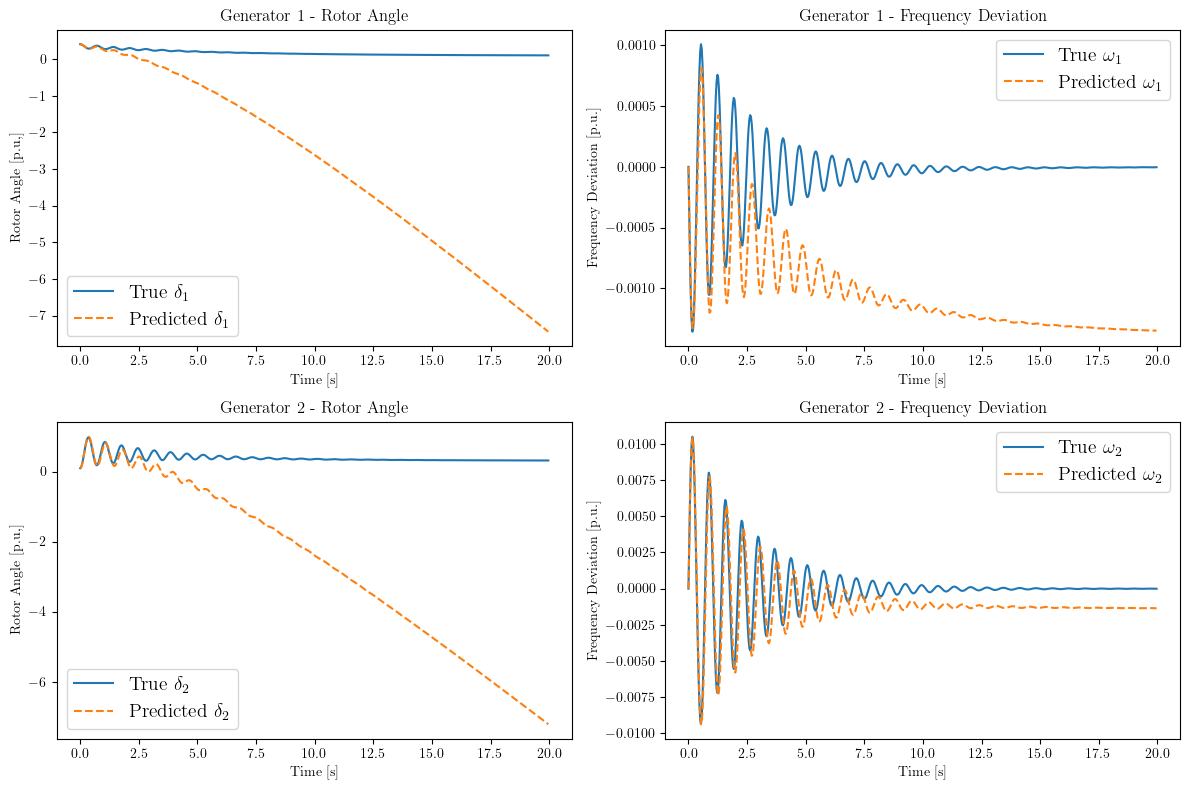


Iteration 0 | Total Loss 0.87021446228027343750
Updated Parameters:
M2: 11.379095077514648
D2: 9.477023124694824
V2: 1.9480198621749878
B: -0.5639559030532837
G: -0.00519318925216794
Pmech2: 0.46409884095191956


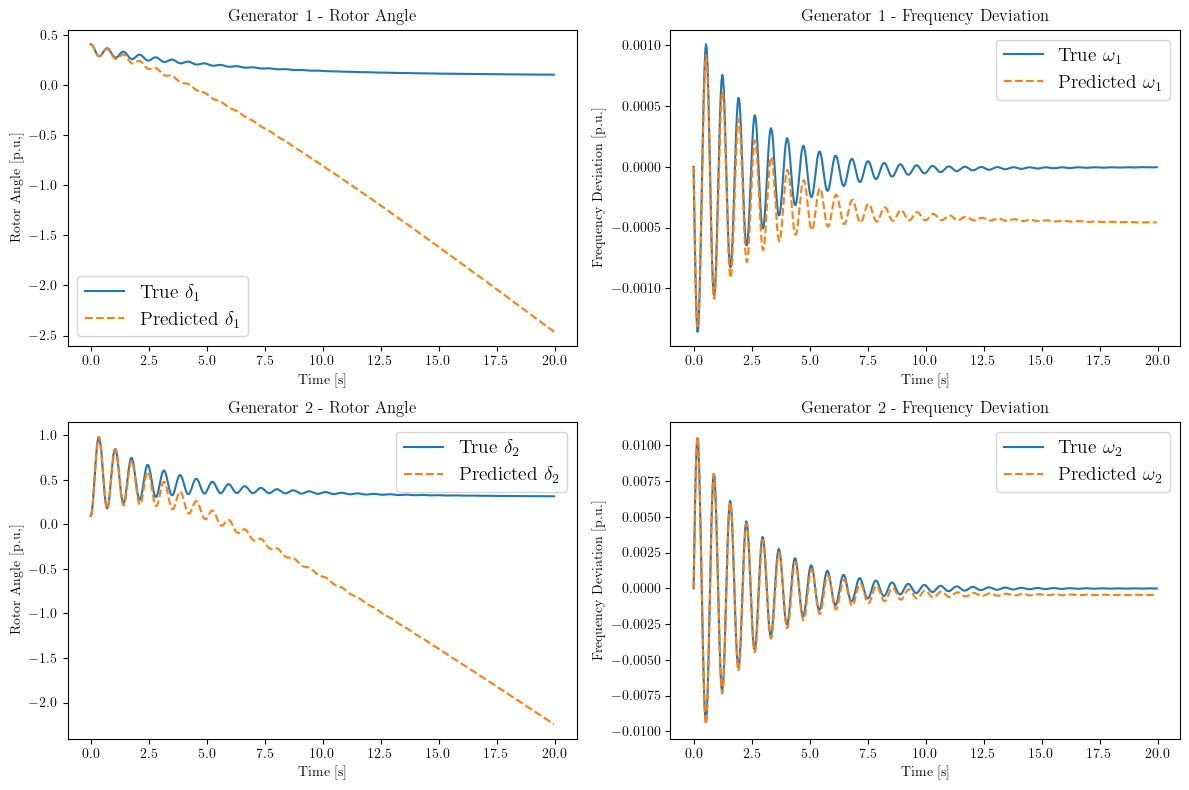

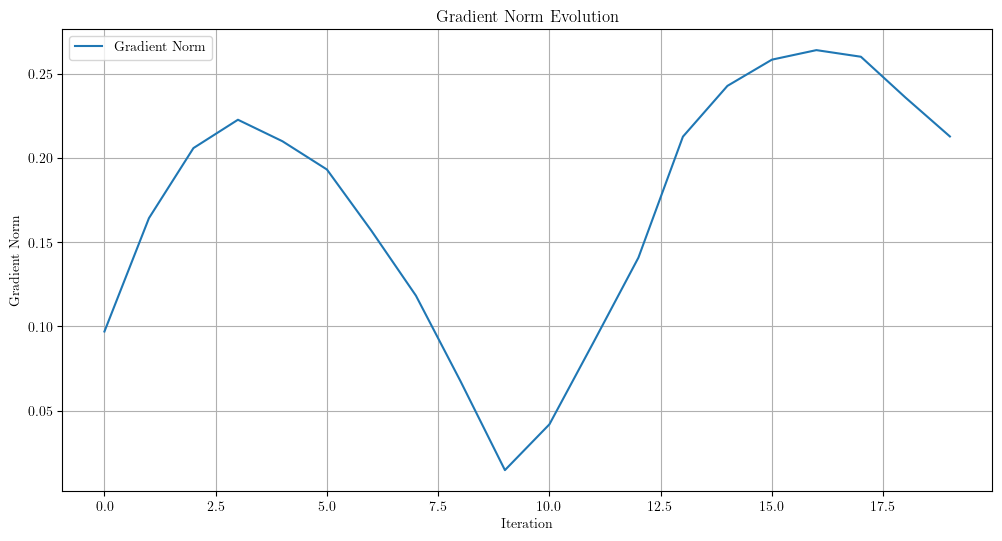


Iteration 20 | Total Loss 0.17500753700733184814
Updated Parameters:
M2: 11.71635627746582
D2: 9.183606147766113
V2: 1.9955028295516968
B: -0.5697906613349915
G: -0.006599761079996824
Pmech2: 0.4652458131313324


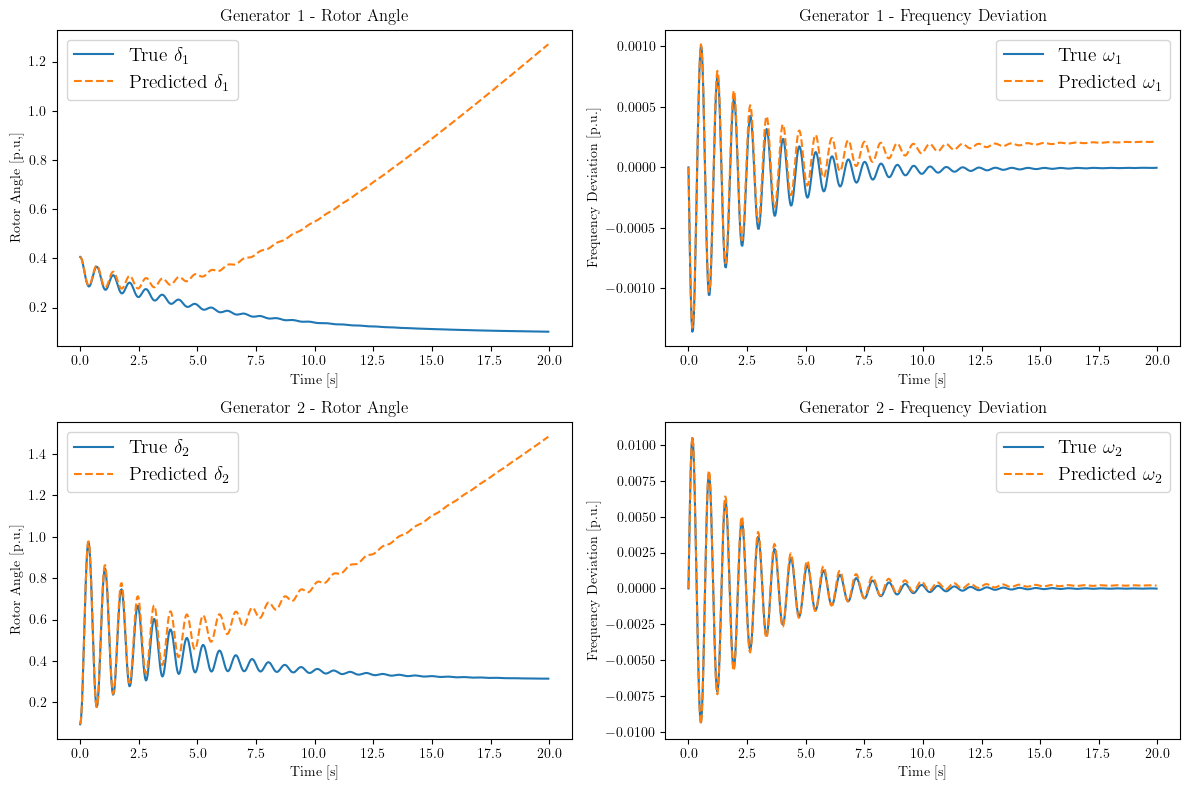

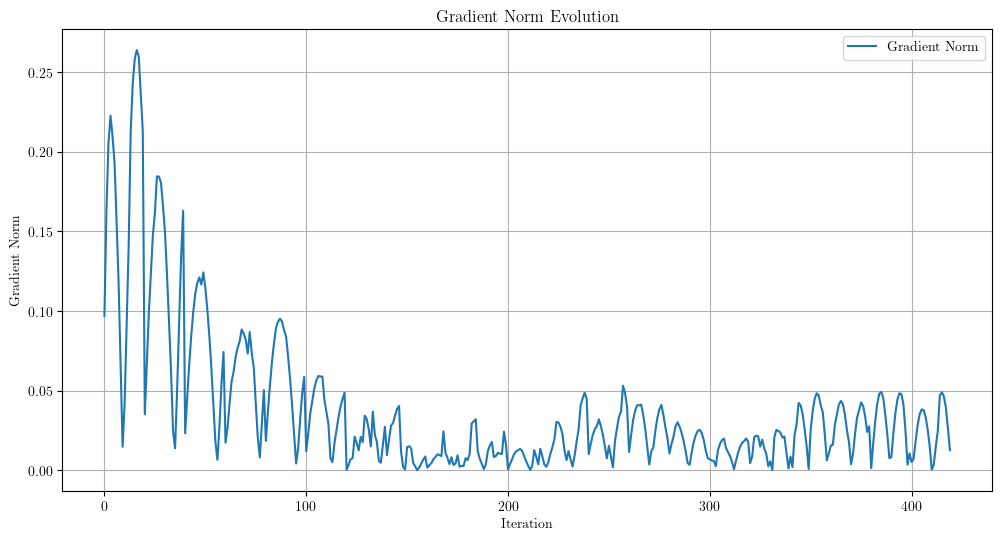


Iteration 40 | Total Loss 0.00386741431429982185
Updated Parameters:
M2: 11.866557121276855
D2: 9.27723217010498
V2: 1.9874396324157715
B: -0.5736650228500366
G: -0.005954563617706299
Pmech2: 0.4658189117908478


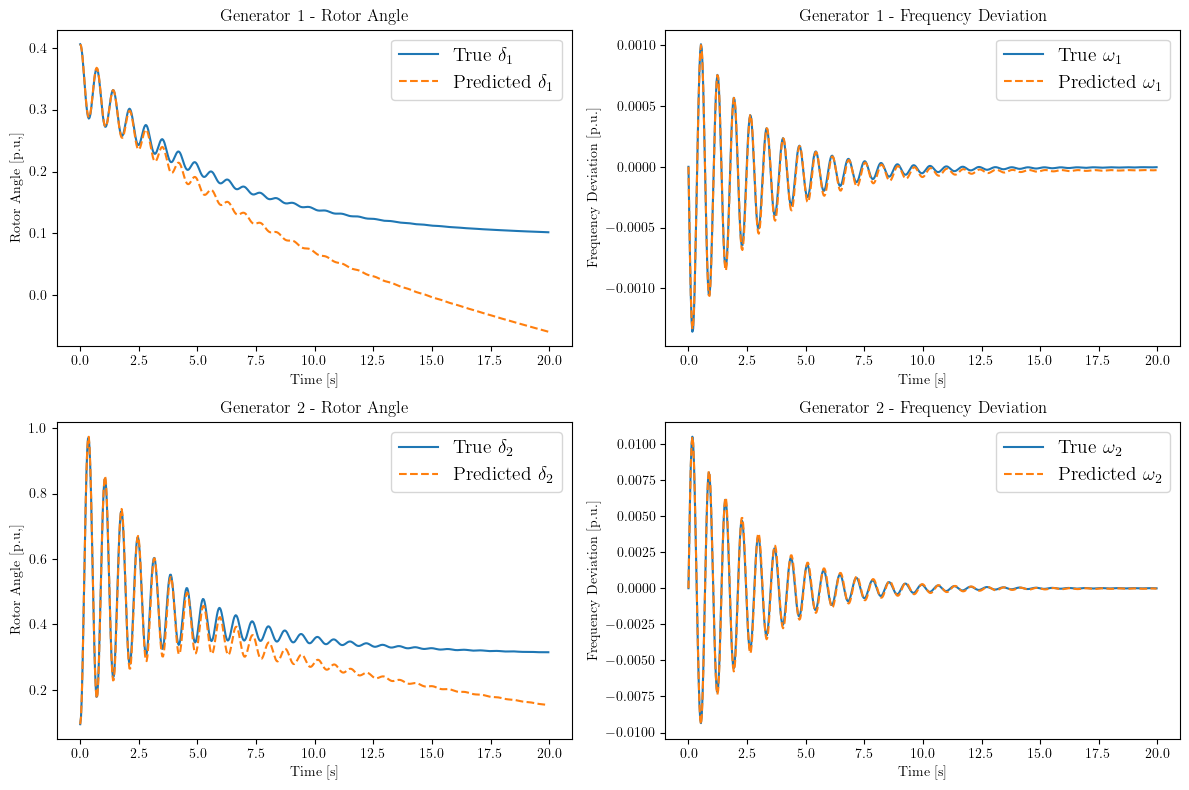

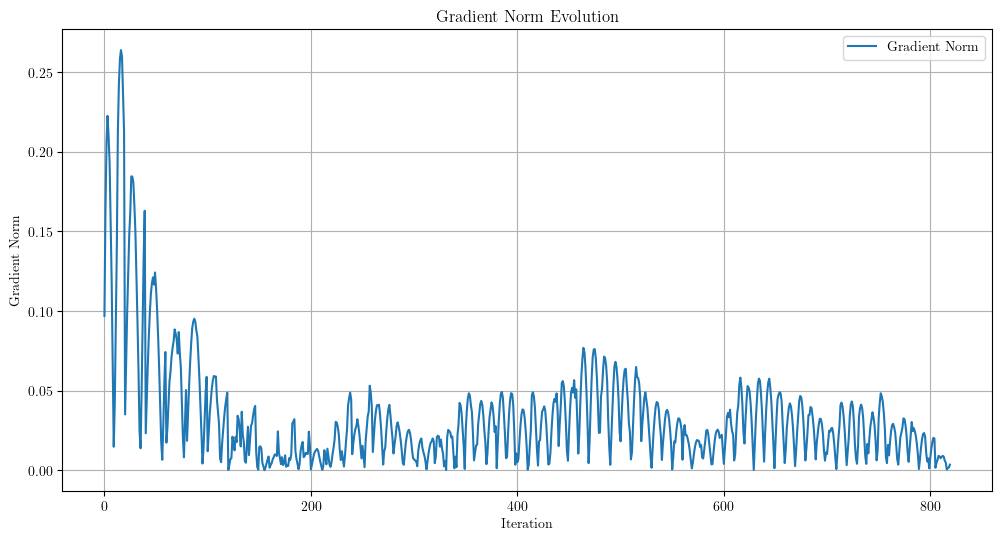


Iteration 60 | Total Loss 0.01917435415089130402
Updated Parameters:
M2: 11.913810729980469
D2: 9.433415412902832
V2: 1.982995867729187
B: -0.574360728263855
G: -0.005757344886660576
Pmech2: 0.46946924924850464


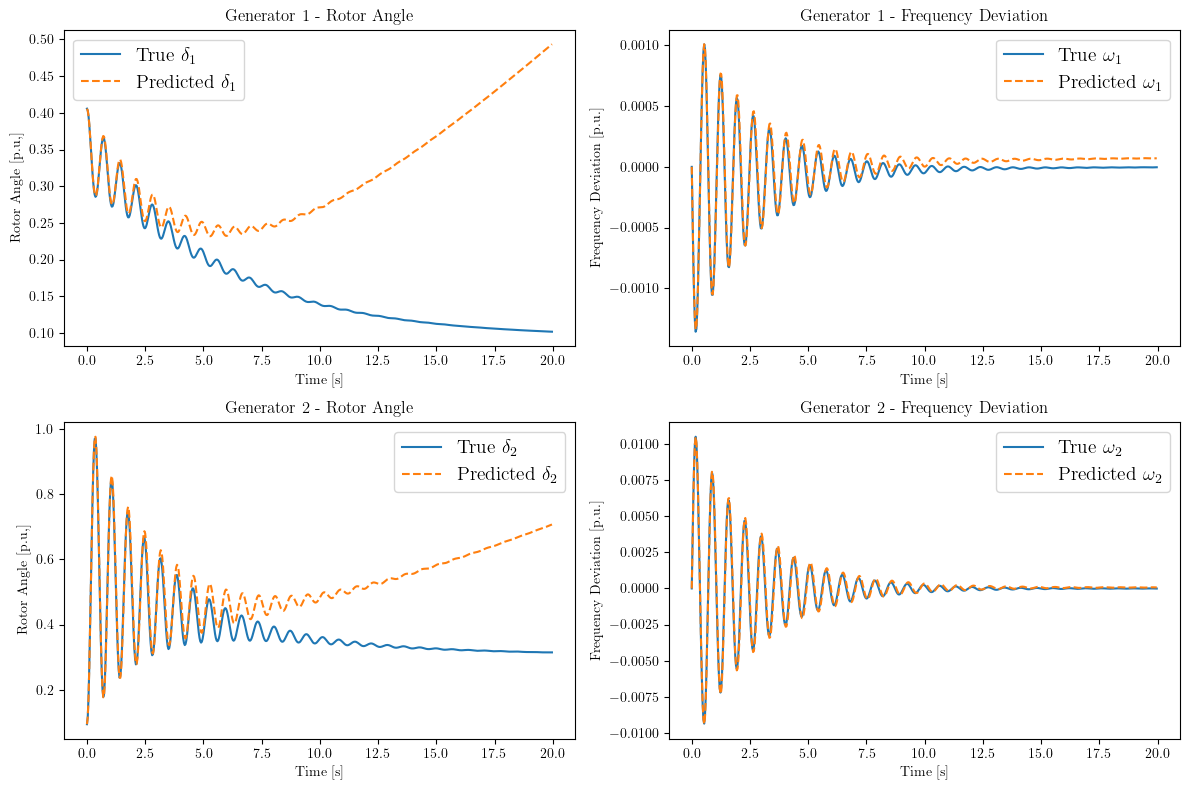

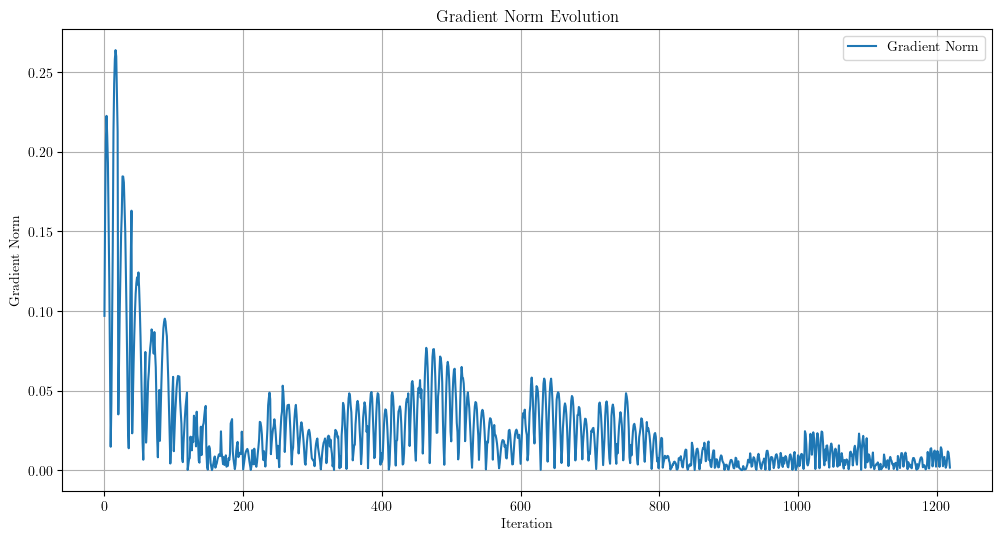


Iteration 80 | Total Loss 0.00155445758718997240
Updated Parameters:
M2: 11.920312881469727
D2: 9.560516357421875
V2: 1.993215560913086
B: -0.57597815990448
G: -0.004861304070800543
Pmech2: 0.4745442271232605


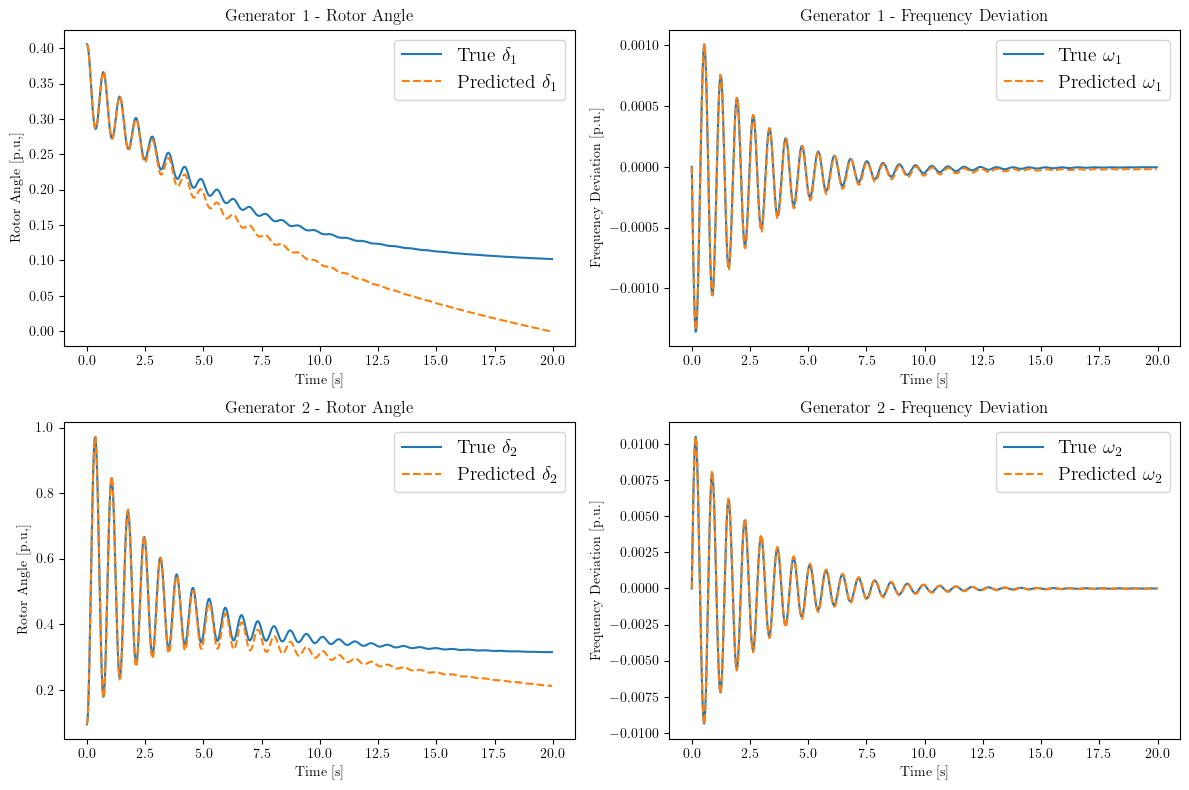

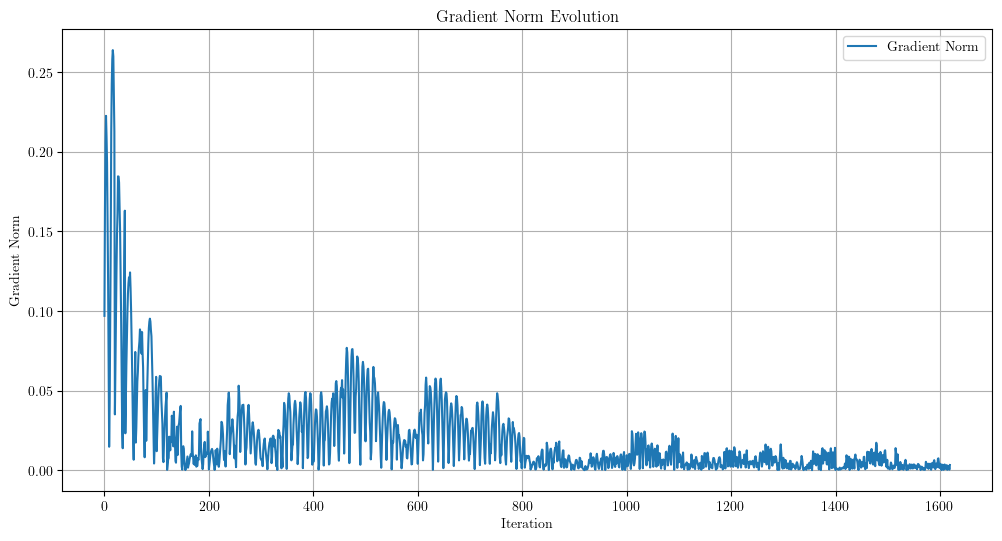


Iteration 100 | Total Loss 0.01276813074946403503
Updated Parameters:
M2: 11.959426879882812
D2: 9.76727294921875
V2: 1.9996050596237183
B: -0.5779184699058533
G: -0.004176918882876635
Pmech2: 0.4791051745414734


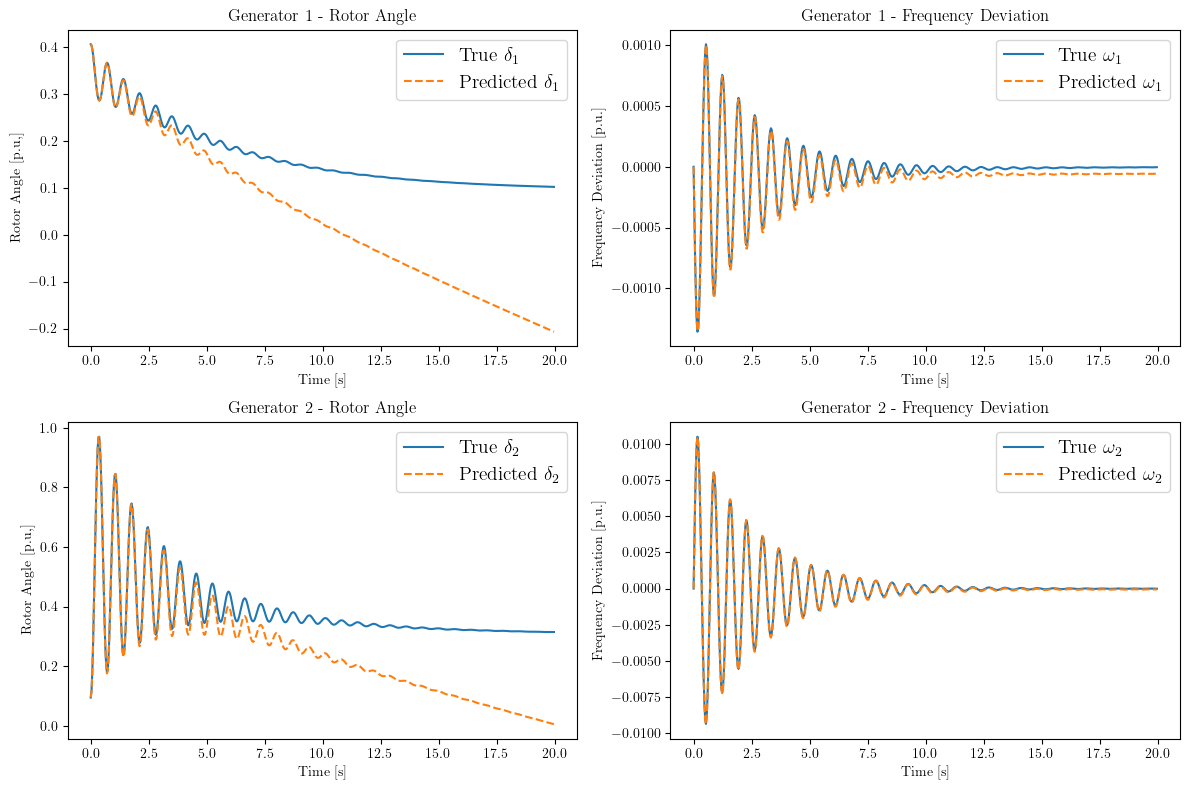

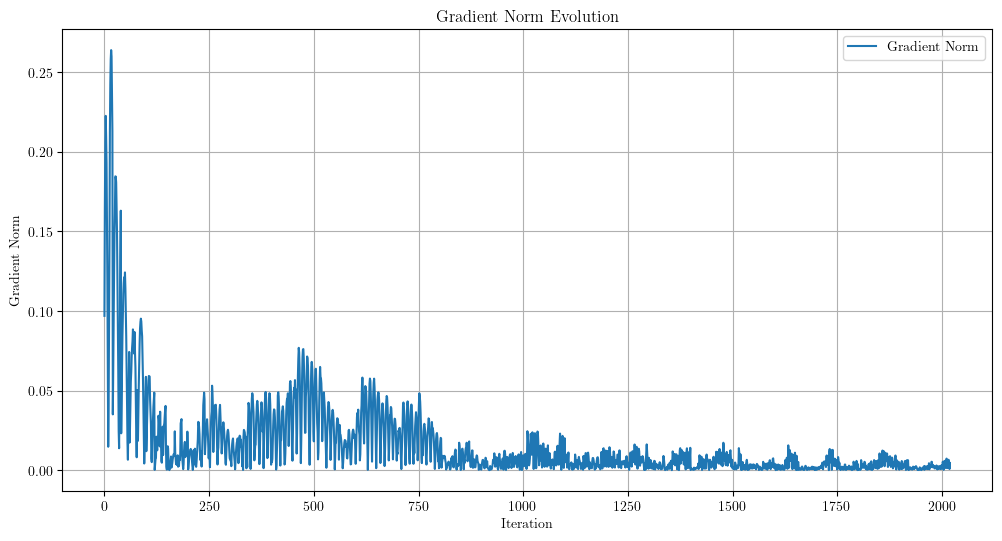


Iteration 120 | Total Loss 0.01605048961937427521
Updated Parameters:
M2: 11.946226119995117
D2: 9.811614036560059
V2: 2.0080459117889404
B: -0.579046905040741
G: -0.004216198343783617
Pmech2: 0.4810391962528229


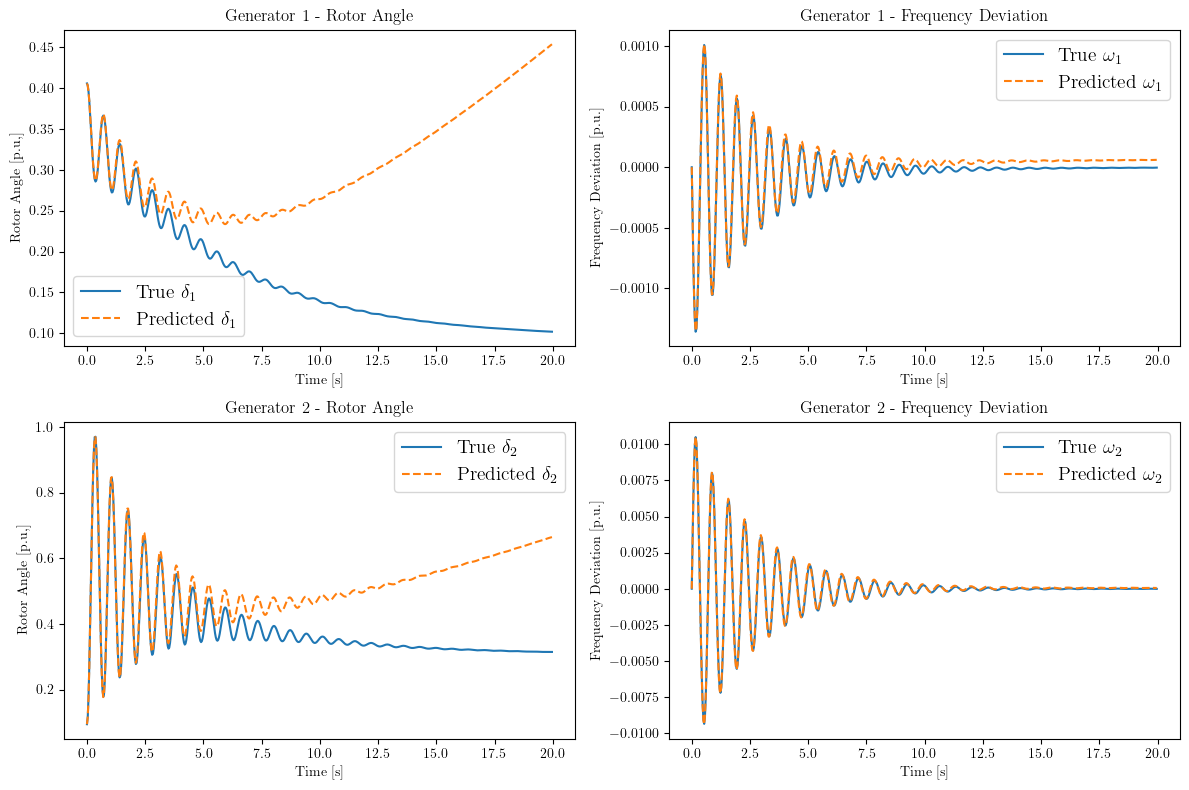

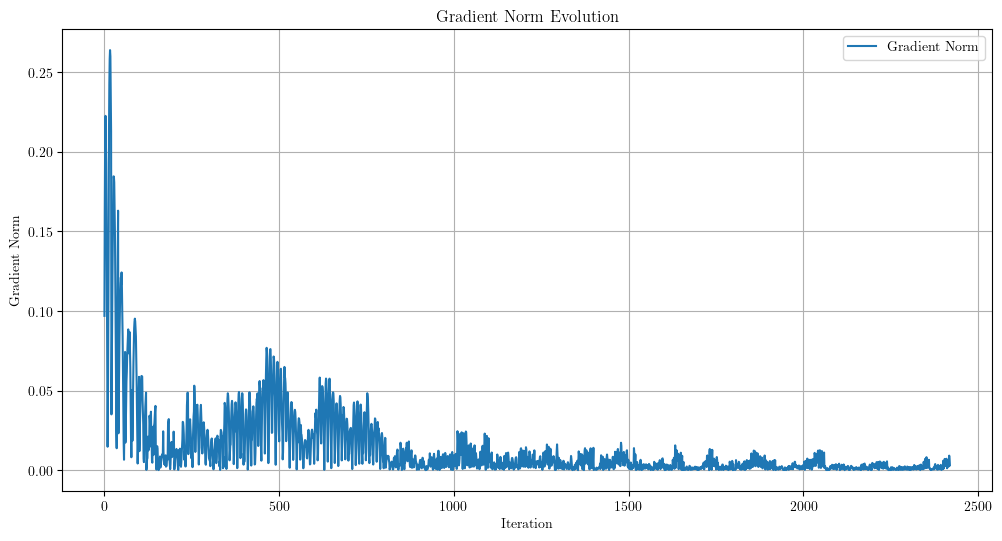


Iteration 140 | Total Loss 0.00226216064766049385
Updated Parameters:
M2: 11.968697547912598
D2: 9.885404586791992
V2: 2.0010197162628174
B: -0.5785458087921143
G: -0.0038197431713342667
Pmech2: 0.4825729727745056


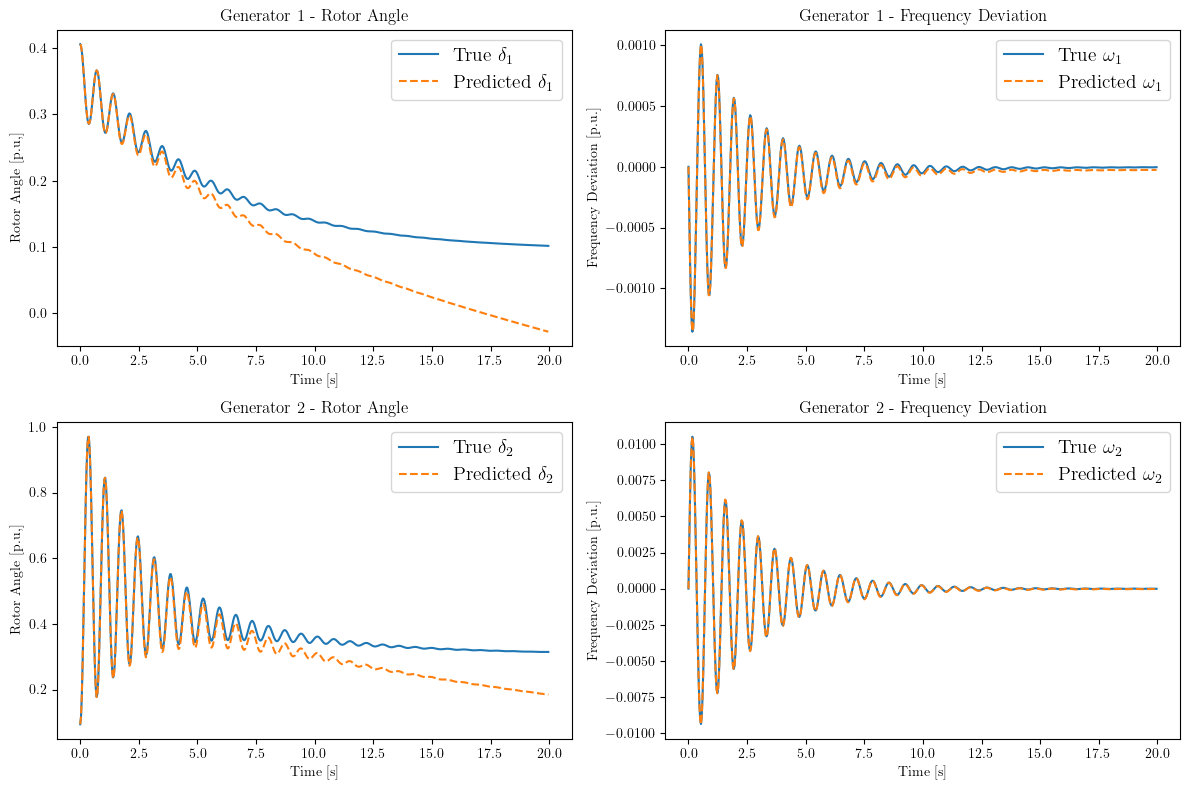

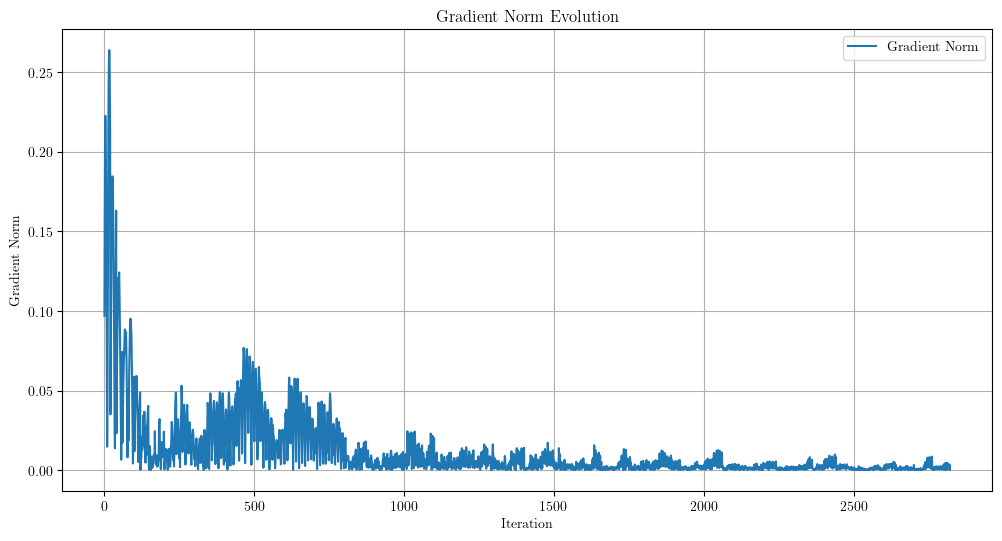


Iteration 160 | Total Loss 0.00250377249903976917
Updated Parameters:
M2: 11.989640235900879
D2: 9.936721801757812
V2: 2.0015926361083984
B: -0.5787731409072876
G: -0.003707593772560358
Pmech2: 0.48443734645843506


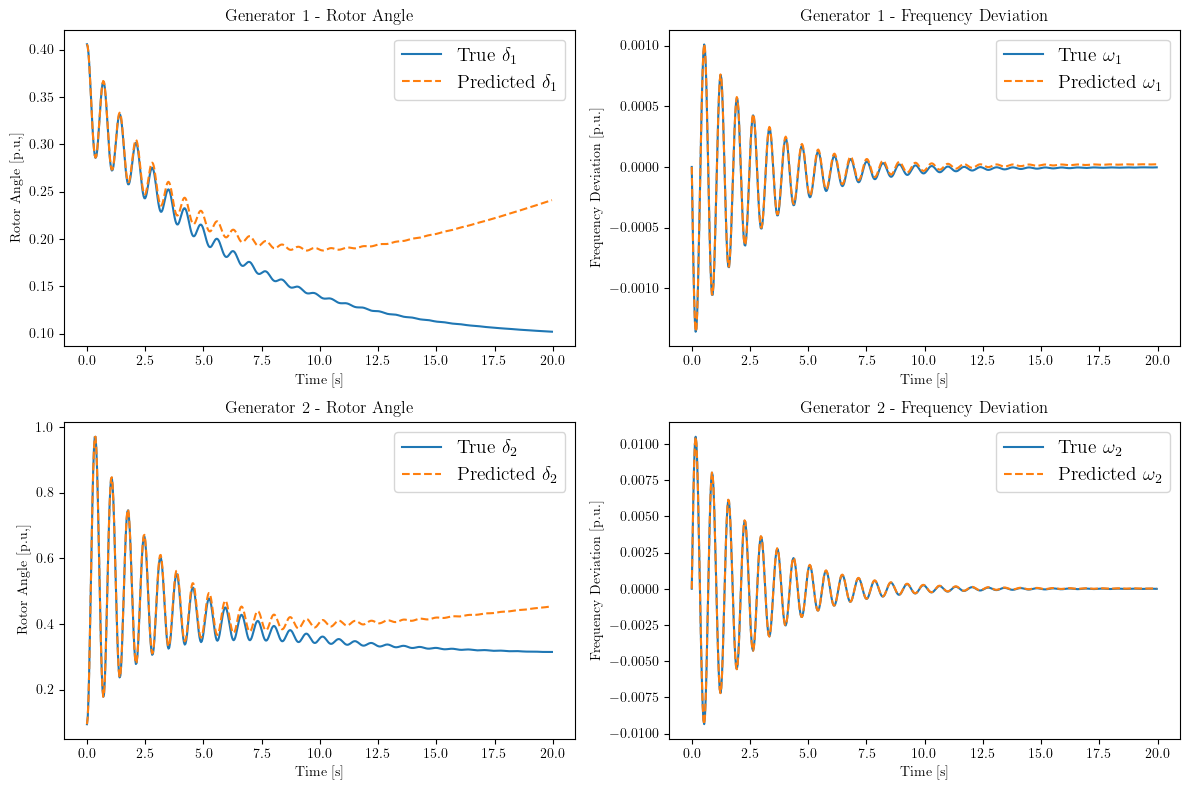

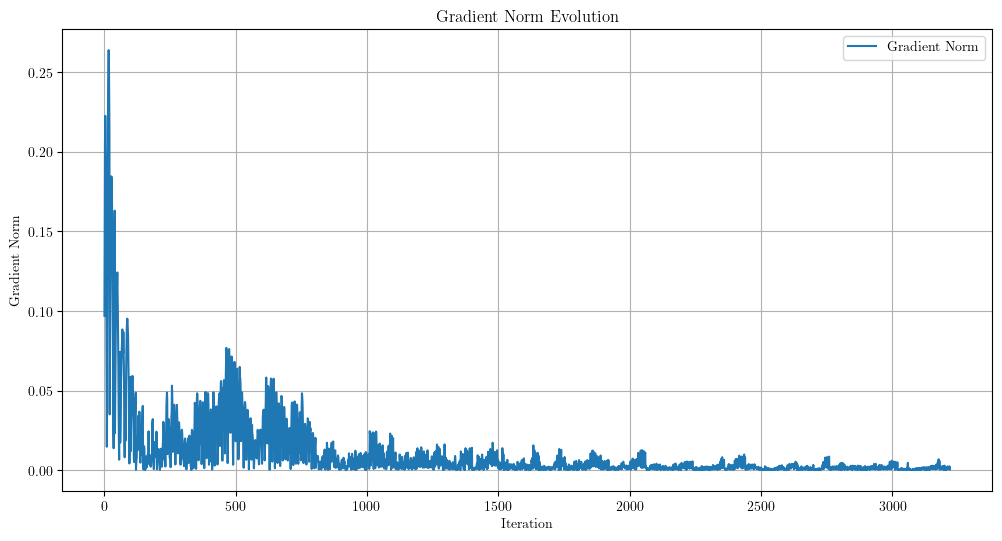


Iteration 180 | Total Loss 0.00006419506826205179
Updated Parameters:
M2: 12.003849029541016
D2: 9.987971305847168
V2: 1.9914945363998413
B: -0.5778694748878479
G: -0.003489878261461854
Pmech2: 0.48575225472450256


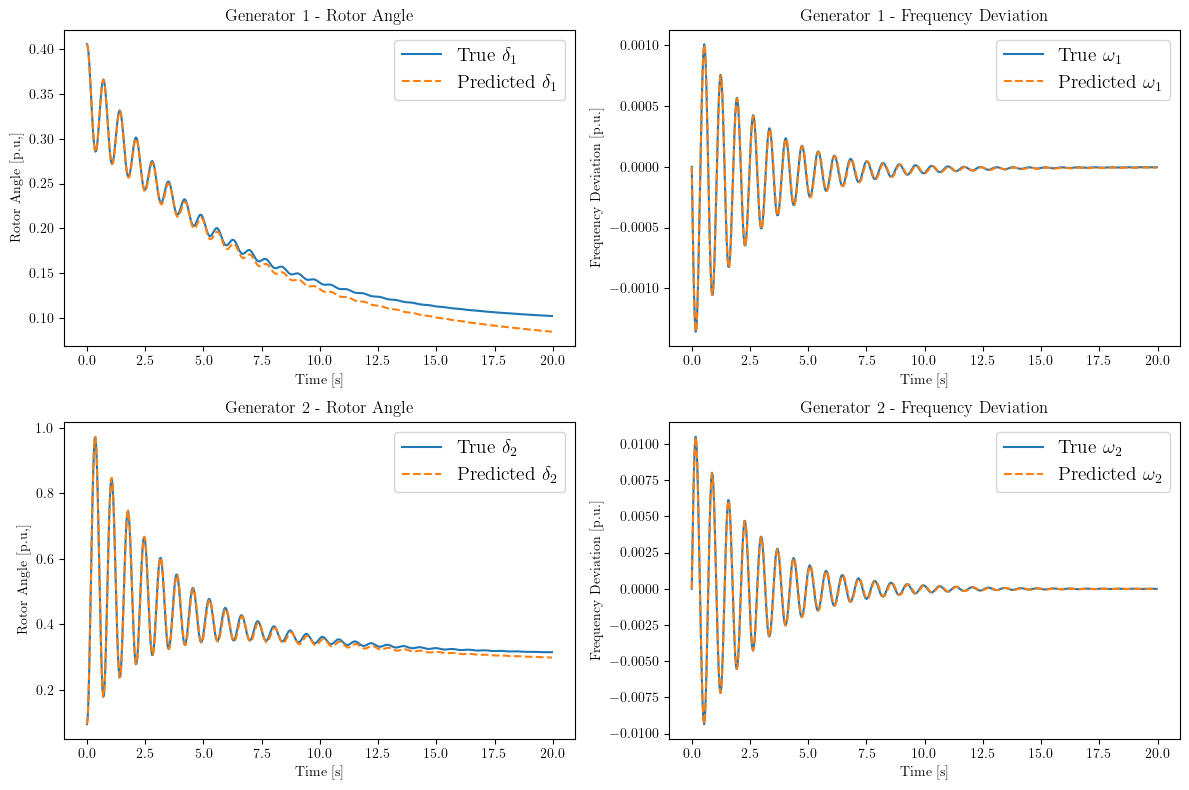

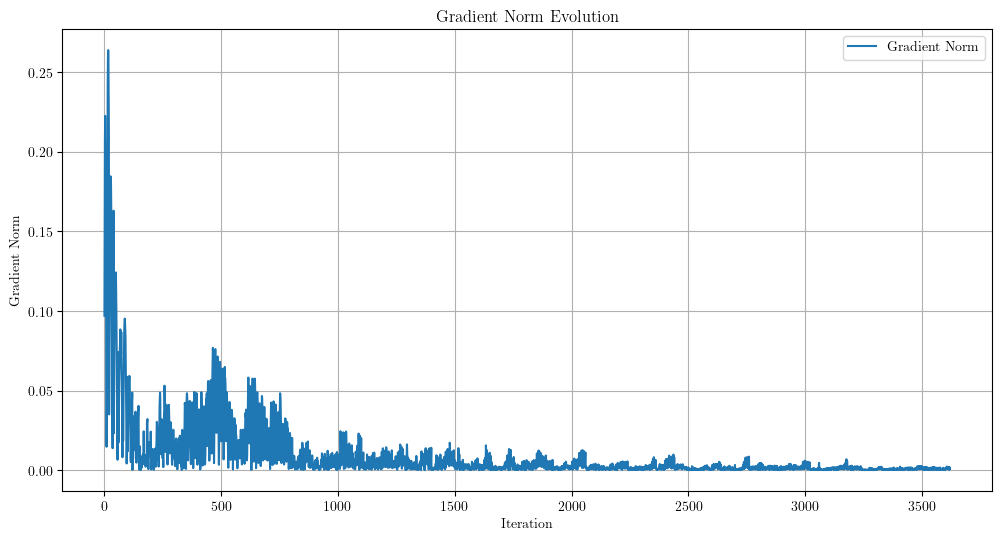


Iteration 200 | Total Loss 0.00006502800533780828
Updated Parameters:
M2: 11.99616527557373
D2: 9.979560852050781
V2: 2.0016276836395264
B: -0.5789035558700562
G: -0.0034492986742407084
Pmech2: 0.4859054982662201


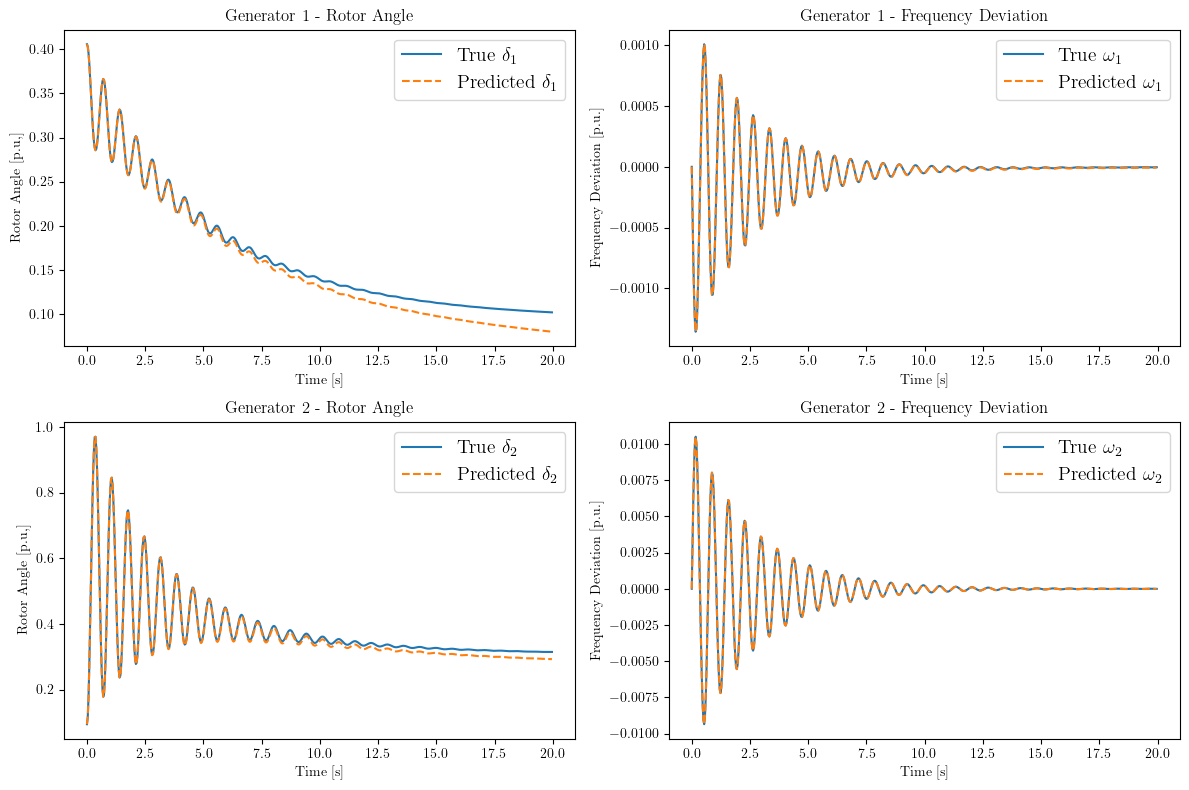

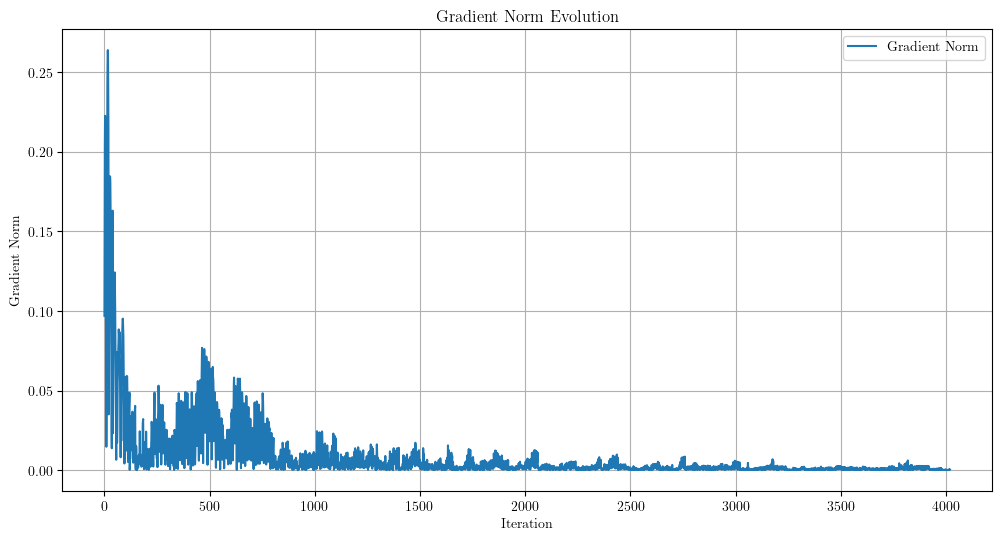


Iteration 220 | Total Loss 0.00004788381193066016
Updated Parameters:
M2: 11.999988555908203
D2: 9.9924955368042
V2: 2.0023703575134277
B: -0.5789923667907715
G: -0.0033933413214981556
Pmech2: 0.48635101318359375


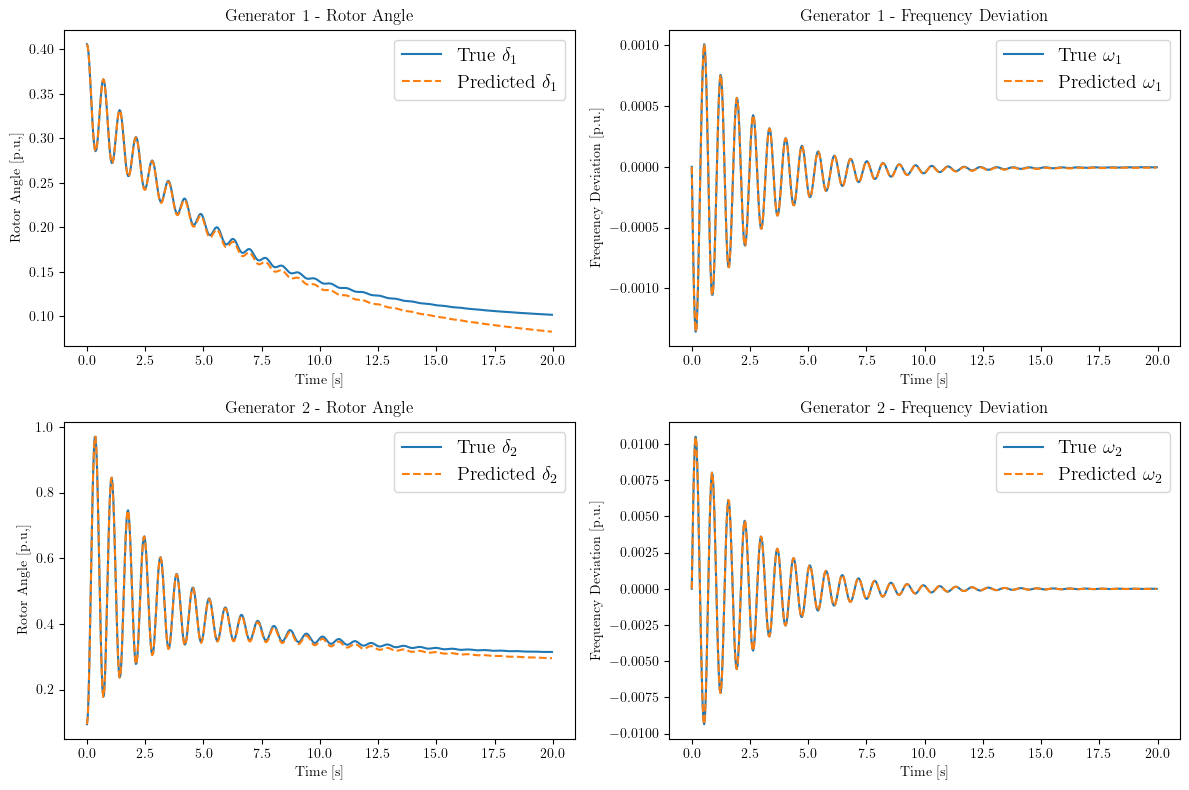

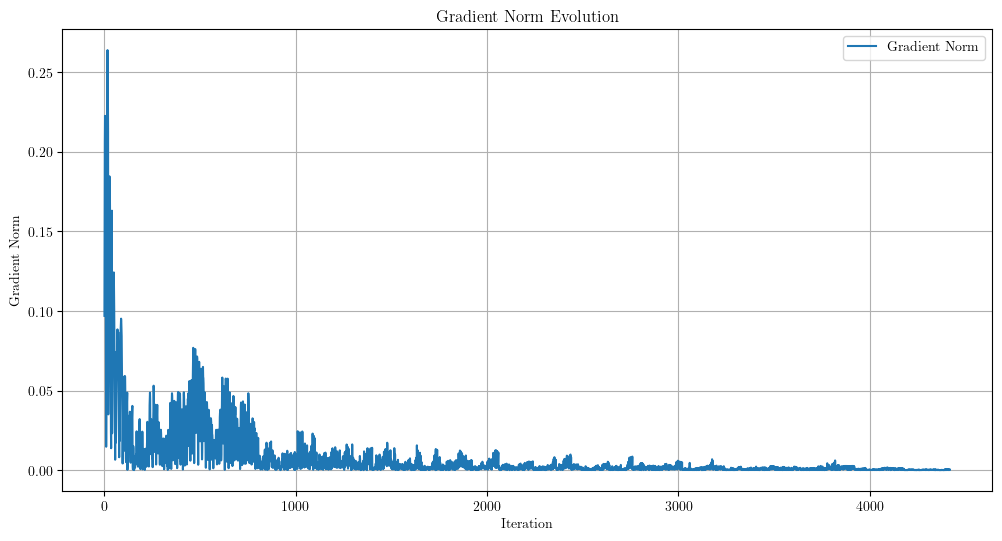


Iteration 240 | Total Loss 0.00002568529635027517
Updated Parameters:
M2: 11.999692916870117
D2: 9.997639656066895
V2: 2.0015878677368164
B: -0.578936755657196
G: -0.0034083600621670485
Pmech2: 0.4863642454147339


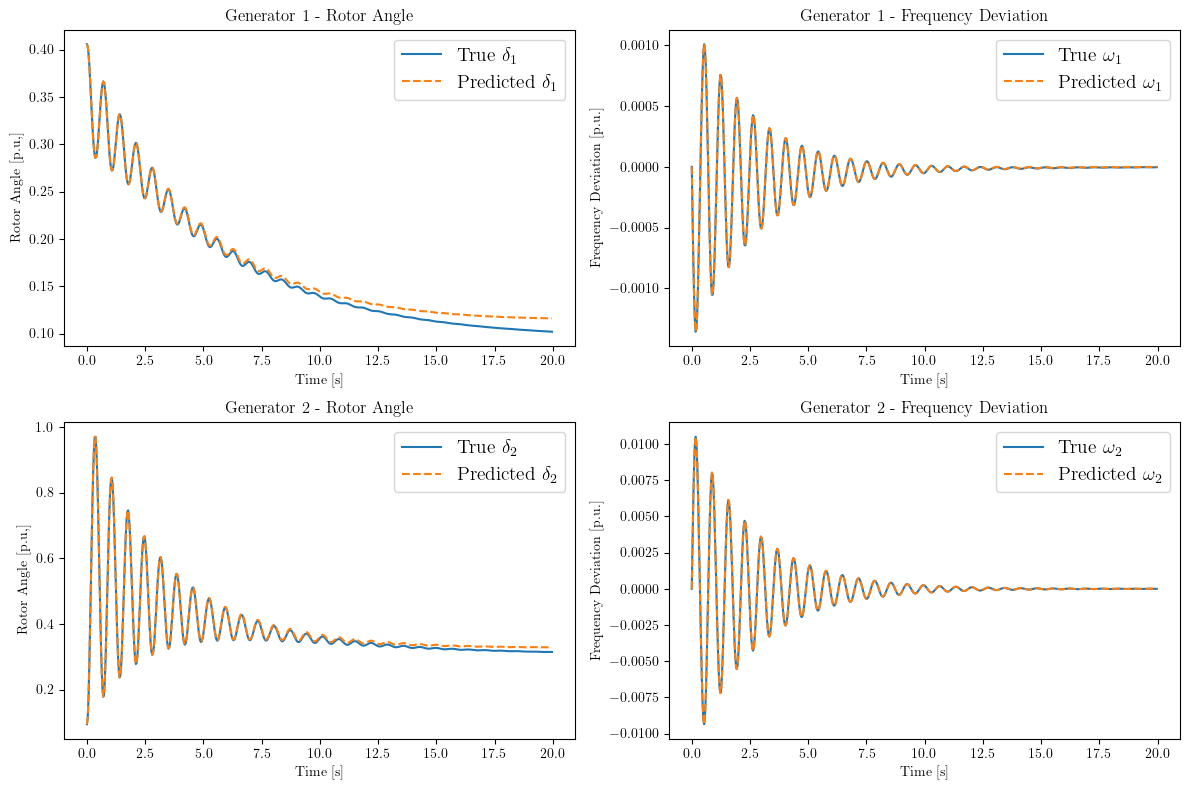

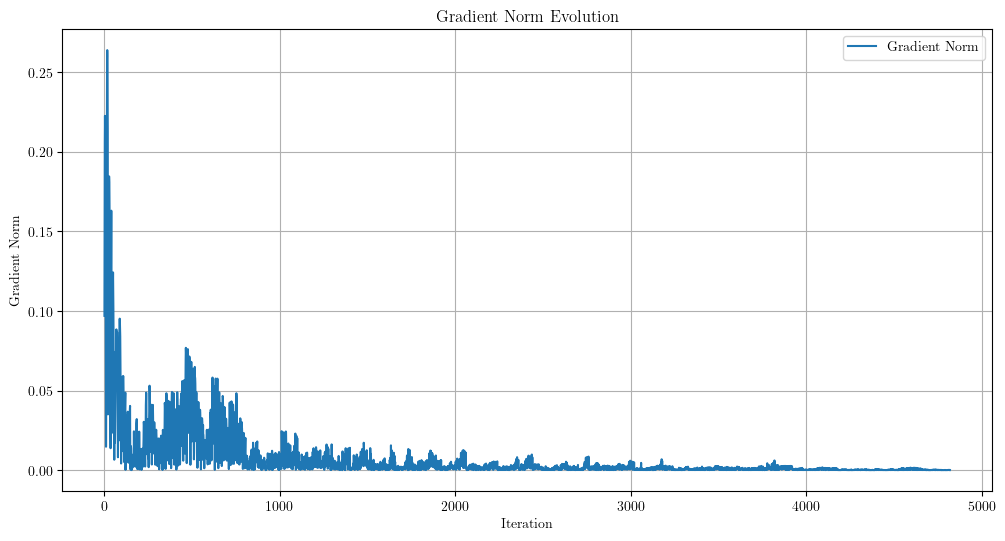


Iteration 260 | Total Loss 0.00000038847562677802
Updated Parameters:
M2: 12.000093460083008
D2: 10.00377082824707
V2: 2.0020482540130615
B: -0.5790615677833557
G: -0.0033804525155574083
Pmech2: 0.48652181029319763


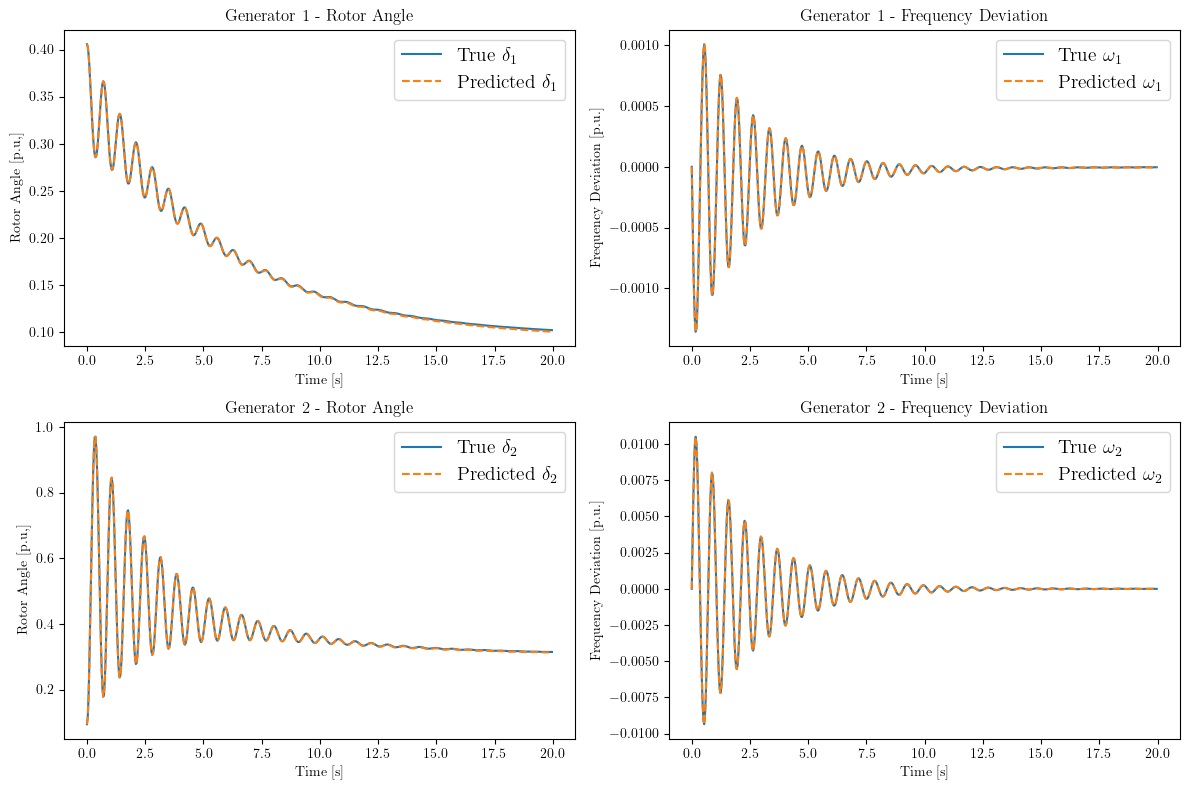

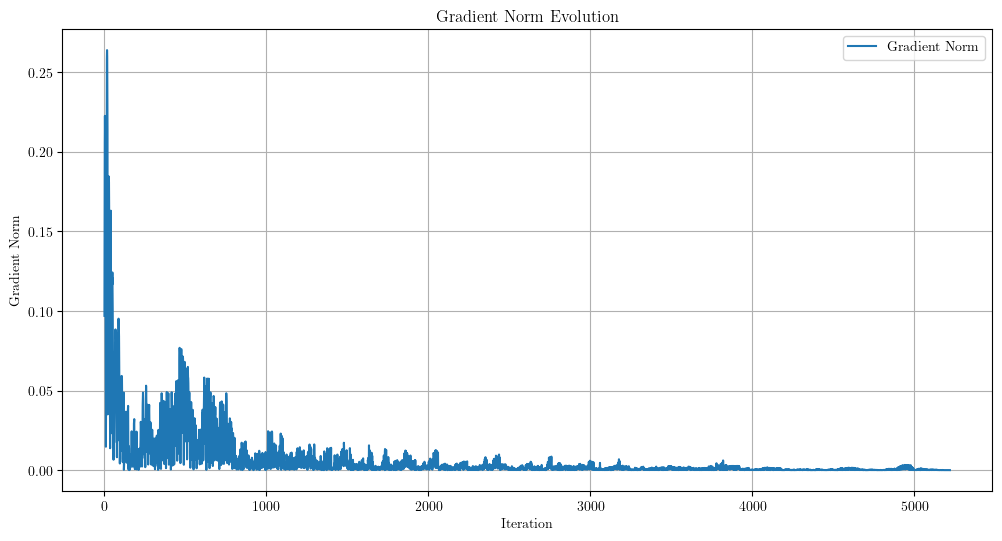

Stopping at iteration 263 as the value of the loss is below the threshold: 1e-11
Loss: 0.00000000000019925667
M2_G: 11.99998378753662109375
D2_G: 10.00222682952880859375
V2_G: 2.00199532508850097656
B_G: -0.57905644178390502930
G_G: -0.00337768672034144402
Pmech2_G: 0.48653438687324523926

Iteration 263 | Total Loss 0.00000263358742813580
Updated Parameters:
M2: 11.999983787536621
D2: 10.002226829528809
V2: 2.001995325088501
B: -0.579056441783905
G: -0.003377686720341444
Pmech2: 0.48653438687324524


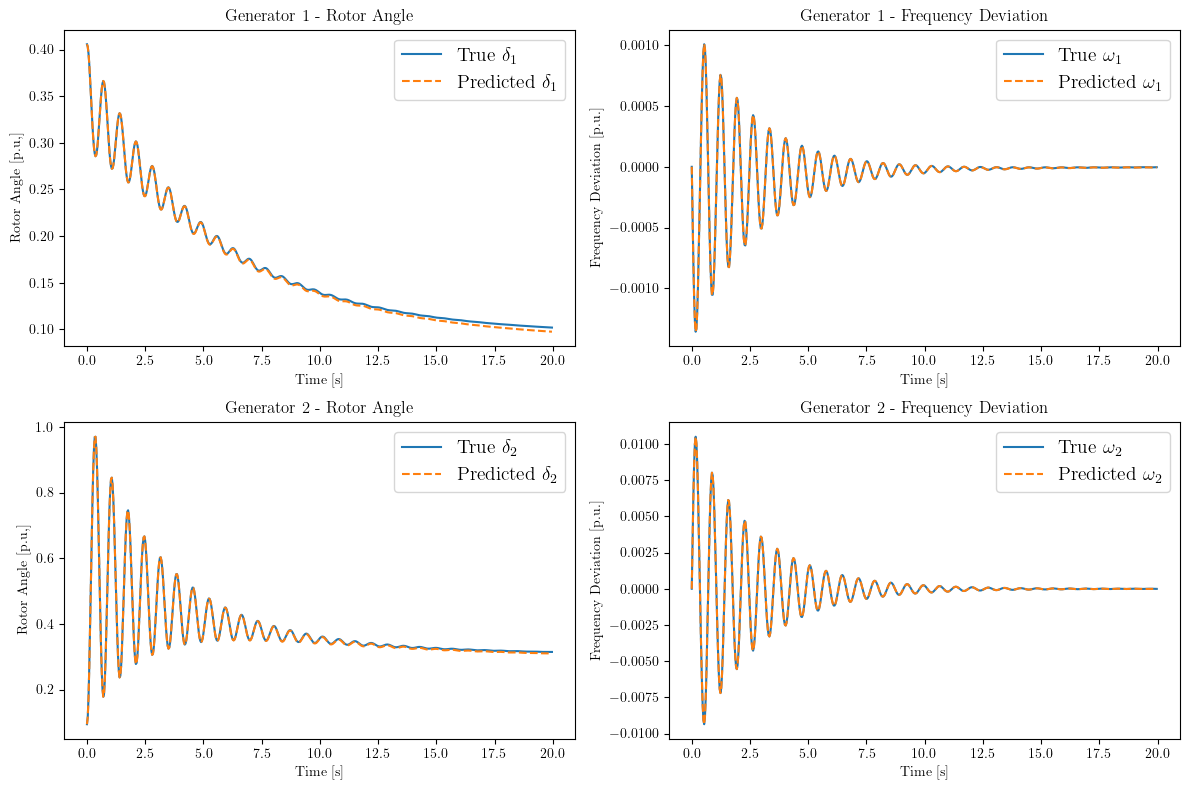

In [14]:
#Training loop - Mac - MDV
Delta = 0.95 #Porcentual deviation from real value
#TargetPercent = 0.01
Treshold = 1e-11 #1e-13 for [MD, MDV], 1e-11 for [MDVP, MDVPBG]
M1_G = M1
D1_G = D1
M2_G = Delta*M2
D2_G = Delta*D2
V1_G = v1star
#V2_G = v2star
V2_G = Delta*v2star
#B_G = Bred
B_G = Delta*Bred
#G_G = Gred
G_G = Delta*Gred
Pmech1_G = Pmech1star
#Pmech2_G = Pmech2star
Pmech2_G = Delta*Pmech2star

parameters_correct = [M1,D1,M2,D2,v1star,v2star,Bred,Gred,Pmech1star,Pmech2star]
parameters_data = []


csv_file_path = "MDVPBG/Data.csv"
plot_save_path = "MDVPBG/Initial.png"

os.makedirs(os.path.dirname(csv_file_path), exist_ok=True)


print(f"M1: {M1.item()}", f"M1_G: {M1_G.item()}")
print(f"D1: {D1.item()}", f"D1_G: {D1_G.item()}")
print(f"M2: {M2.item()}", f"M2_G: {M2_G.item()}")
print(f"D2: {D2.item()}", f"D2_G: {D2_G.item()}")
print(f"V1: {v1star.item()}", f"V1_G: {V1_G.item()}")
print(f"V2: {v2star.item()}", f"V2_G: {V2_G.item()}")
print(f"Bred: {Bred.item()}", f"B_G: {B_G.item()}")
print(f"Gred: {Gred.item()}", f"G_G: {G_G.item()}")
print(f"Pmech1: {Pmech1star.item()}", f"Pmech1_G: {Pmech1_G.item()}")
print(f"Pmech2: {Pmech2star.item()}", f"Pmech2_G: {Pmech2_G.item()}")

func = NeuralODE(M1_G, D1_G, M2_G, D2_G, V1_G, V2_G, B_G, G_G, Pmech1_G, Pmech2_G).to(device)
normal_lr = 0.001
special_lr = 0.0001
special_param = [func.Pmech2, func.B, func.G]
other_param = [param for name, param in func.named_parameters() if param not in special_param]
param_groups = [{'params': other_param, 'lr': normal_lr}, {'params': special_param, 'lr': special_lr}]
optimizer = torch.optim.RMSprop(param_groups) #RMSprop
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 100, gamma=0.5, verbose=False)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.005, epochs=1000, steps_per_epoch=20)

ii = 0

with torch.no_grad():
    print('Initial Parameters:')
    for name, param in func.named_parameters():
        print(f"{name}: {param.data}")
    initial_pred = odeint(func,x0,t).to(device)
    initial_true = true_x.to(device)
    visualize(initial_true, initial_pred, t, omega0, viz, plot_save_path)

grad_norm_values = []
start_time = time.time()

for itr in range(0, niters):
    grad_norm = 0
    optimizer.zero_grad()
    s, batch_x0, batch_t, batch_x = get_batch()

    for batch_n in range(0,batch_size):
        low = int(s[batch_n])
        high = low + batch_time
        pred_x = odeint(func, batch_x0[batch_n], batch_t, method = method).to(device)
        #loss = torch.mean((pred_x - batch_x[:,batch_n,:,:])**2) #loss using all states.
        loss = torch.mean((pred_x[:,0:2,0] - batch_x[:,batch_n,0:2,0])**2) #loss using only delta1 and omega1.
        loss.backward() #Calculate the dloss/dparameters
        optimizer.step() #Update value of parameters
        #scheduler.step() - For cyclic scheduler
        #print(f'\nBatch {batch_n:d} | Loss {loss.item():.20f}')

        with torch.no_grad():
            for name, param in func.named_parameters():
                if name in ['M2', 'D2', 'V2', 'Pmech2']:
                    param.clamp_(min=0.1)    
                if name in ['B', 'G']:
                    param.clamp_(max=-0.00001)

        for param in func.parameters():
            if param.grad is not None:
                grad_norm = param.grad.data.norm(2).item()**2
        grad_norm = math.sqrt(grad_norm)
        grad_norm_values.append(grad_norm)

        current_parameters = [param.item() for name, param in func.named_parameters()]
        iteration_time = time.time() - start_time
        parameters_data.append([itr] + current_parameters + [loss.item(), iteration_time, grad_norm])

    if itr % test_freq == 0:
        with torch.no_grad():
            pred_x = odeint(func, x0, t).to(device)
            #loss = torch.mean((pred_x - true_x)**2) #Loss using all states.
            loss = torch.mean((pred_x[:,0:2,0] - true_x[:,0:2,0])**2) #Loss using only delta1 and omega1.
            print(f'\nIteration {itr:d} | Total Loss {loss.item():.20f}')
            print('Updated Parameters:')
            for name, param in func.named_parameters():
                print(f"{name}: {param.data}")
            plot_save_path = f'MDVPBG/Iteration_{itr}.png'
            visualize(true_x, pred_x, t, omega0, viz, plot_save_path)
            
            with open(csv_file_path, 'a', newline='') as csvfile:
                writer = csv.writer(csvfile)
                if itr == 0:
                    header = ['Iteration'] + [name for name, _ in func.named_parameters()] + ['Loss', 'Time', 'Gradient Norm']
                    writer.writerow(header)
                writer.writerows(parameters_data)
                parameters_data = []
            ii += 1

            plt.figure(figsize=(12, 6))
            plt.plot(grad_norm_values, label= 'Gradient Norm')
            plt.xlabel('Iteration')
            plt.ylabel('Gradient Norm')
            plt.title('Gradient Norm Evolution')
            plt.legend()
            plt.grid(True)
            plt.show()

    scheduler.step()
    end = time.time()

    #if grad_norm <= Treshold:
    if loss <= Treshold:
         print(f'Stopping at iteration {itr} as the value of the loss is below the threshold: {Treshold}')
         print(f'Loss: {loss.item():.20f}')
         print(f'M2_G: {func.M2.item():.20f}')
         print(f'D2_G: {func.D2.item():.20f}')
         print(f'V2_G: {func.V2.item():.20f}')
         print(f'B_G: {func.B.item():.20f}')
         print(f'G_G: {func.G.item():.20f}')
         print(f'Pmech2_G: {func.Pmech2.item():.20f}')

         with torch.no_grad():
             pred_x = odeint(func, x0, t).to(device)
             #loss = torch.mean((pred_x - true_x)**2) #Loss using all states.
             loss = torch.mean((pred_x[:,0:2,0] - true_x[:,0:2,0])**2) #Loss using only delta1 and omega1.
             print(f'\nIteration {itr:d} | Total Loss {loss.item():.20f}')
             print('Updated Parameters:')
             for name, param in func.named_parameters():
                 print(f"{name}: {param.data}")
             plot_save_path = f'MDVPBG/Iteration_{itr}.png'
             visualize(true_x, pred_x, t, omega0, viz, plot_save_path)
             with open(csv_file_path, 'a', newline='') as csvfile:
                 writer = csv.writer(csvfile)
                 writer.writerows(parameters_data)
         break
